## Import Scores Data and perform further cleaning by adding season column

In [1]:
import pandas as pd
import numpy as np
scores = pd.read_csv('hs_bsktbl_scores_clean.csv', index_col=0)
scores['season'] = 2000
scores = scores[scores['home_score'] > 0]
scores = scores[scores['away_score'] > 0]
for season in [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]:
    scores.loc[(((scores['year'] == season-1) & (scores['month'] >= 10)) | ((scores['year'] == season) & (scores['month'] <= 4))), 'season'] = season

## Tune Model Parameters by looping through different input combinations and calculating the accuracy in predicting game outcomes
<b>Paramters to be tuned:</b><br>
<i>Reset Rate</i>: The percentage of a school's ELO Rating away from 1500 that is kept after each season<br>
<i>Home Field Advantage</i>: The size of the ELO Bonus that is given to the home team<br>
<i>Win Bonus(Learning Rate)</i>: The ELO Bonus that is given for winning/losing the game<br>

In [7]:
reset_list = []
HFA_list = []
lr_list = []
accuracy_list = []
prog_count = 0
for reset in [0.3, 0.35, 0.4, 0.45, 0.5]:
    for advantage in [5,10,15,20,25]:
        for lr in [6,8,10,12,14]:
            elo_dict = {}
            team_date_dict = {}
            for school in scores['away_team'].unique().tolist():
                team_date_dict[school] = {}
                elo_dict[school] = 1500
            for school in scores['home_team'].unique().tolist():
                team_date_dict[school] = {}
                elo_dict[school] = 1500
            HFA = advantage
            learning_rate = lr
            reset_rate = reset
            prediction_sum = 0
            game_sum = 0
            for year in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]:
                season = scores[scores['season'] == year].reset_index(drop=True)
                season = season.sort_values(by='date').reset_index(drop=True)
                for key in elo_dict.keys():
                    elo_dict[key] = ((elo_dict[key] - 1500) * reset_rate) + 1500
                for row in range(len(season)):
                    date = season['date'].iloc[row]
                    away_team = season['away_team'].iloc[row]
                    away_score = season['away_score'].iloc[row]
                    home_team = season['home_team'].iloc[row]
                    home_score = season['home_score'].iloc[row]
                    home_elo = elo_dict[home_team]
                    away_elo = elo_dict[away_team]
                    home_expected = (home_elo+HFA) / (home_elo+HFA+away_elo)
                    elo_diff = home_elo+HFA-away_elo
                    home_actual = home_score / (home_score + away_score)
                    if home_score > away_score:
                        home_bonus = learning_rate
                    else:
                        home_bonus = -learning_rate
                    elo_change = 100*(home_actual-home_expected) + home_bonus
                    elo_dict[home_team] = home_elo + elo_change
                    team_date_dict[home_team][date] = elo_dict[home_team]
                    elo_dict[away_team] = away_elo - elo_change
                    team_date_dict[away_team][date] = elo_dict[away_team]
                    home_expected_win_pct = 1/(10**((-1*elo_diff)/400)+1)
                    away_expected_win_pct = 1-home_expected_win_pct
                    if home_expected_win_pct > 0.5:
                        points_home_win = 2*((-100*(home_expected_win_pct-.5)**2) + 100*(home_expected_win_pct-.5))
                        points_away_win = -((home_expected_win_pct - .5)*400 - points_home_win)
                    elif home_expected_win_pct < 0.5:
                        points_away_win = 2*((-100*(away_expected_win_pct-.5)**2) + 100*(away_expected_win_pct-.5))
                        points_home_win = -((away_expected_win_pct - .5)*400 - points_away_win)
                    else:
                        points_home_win = 0
                        points_away_win = 0
                    if home_score > away_score:
                        prediction_score = points_home_win
                    elif home_score < away_score:
                        prediction_score = points_away_win
                    else:
                        prediction_score = 0
                    prediction_sum = prediction_sum + prediction_score
                game_sum = game_sum + len(season) 
            accuracy_list.append(prediction_sum/game_sum)
            lr_list.append(lr)
            reset_list.append(reset)
            HFA_list.append(advantage)
            prog_count = prog_count + 1
            print(str(prog_count*.8)[:3]+'% Complete')
results_df = pd.DataFrame()
results_df['Win Bonus'] = lr_list
results_df['Yearly Reset'] = reset_list
results_df['Home Bonus'] = HFA_list
results_df['Accuracy'] = accuracy_list

0.8% Complete
1.6% Complete
2.4% Complete
3.2% Complete
4.0% Complete
4.8% Complete
5.6% Complete
6.4% Complete
7.2% Complete
8.0% Complete
8.8% Complete
9.6% Complete
10.% Complete
11.% Complete
12.% Complete
12.% Complete
13.% Complete
14.% Complete
15.% Complete
16.% Complete
16.% Complete
17.% Complete
18.% Complete
19.% Complete
20.% Complete
20.% Complete
21.% Complete
22.% Complete
23.% Complete
24.% Complete
24.% Complete
25.% Complete
26.% Complete
27.% Complete
28.% Complete
28.% Complete
29.% Complete
30.% Complete
31.% Complete
32.% Complete
32.% Complete
33.% Complete
34.% Complete
35.% Complete
36.% Complete
36.% Complete
37.% Complete
38.% Complete
39.% Complete
40.% Complete
40.% Complete
41.% Complete
42.% Complete
43.% Complete
44.% Complete
44.% Complete
45.% Complete
46.% Complete
47.% Complete
48.% Complete
48.% Complete
49.% Complete
50.% Complete
51.% Complete
52.% Complete
52.% Complete
53.% Complete
54.% Complete
55.% Complete
56.% Complete
56.% Complete
57.% C

## 3-D Graph showing 1st distribution (Red is better, Blue is worse)
### Home Bonus: 0, 10, 20, 30, 40
### Yearly Reset: 0.0, 0.2, 0.4, 0.6, 0.8
### Win Bonus: 5, 15, 25, 35, 45

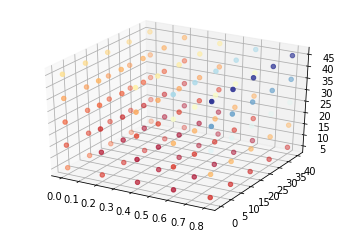

In [4]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
zdata = results_df['Win Bonus'].tolist()
xdata = results_df['Yearly Reset'].tolist()
ydata = results_df['Home Bonus'].tolist()
color_data = results_df['Accuracy'].tolist()
ax.scatter3D(xdata,ydata,zdata,c=color_data,cmap='RdYlBu_r')
plt.show()

## 3-D Graph showing 2nd Distribution
### Home Bonus: 10, 25, 40, 55, 70
### Yearly Reset: 0.3, 0.4, 0.5, 0.6, 0.7
### Win Bonus: 5, 10, 15, 20, 25

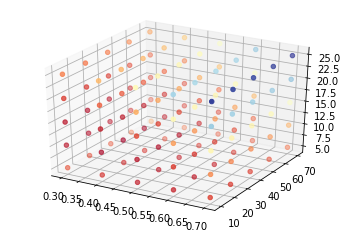

In [6]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
zdata = results_df['Win Bonus'].tolist()
xdata = results_df['Yearly Reset'].tolist()
ydata = results_df['Home Bonus'].tolist()
color_data = results_df['Accuracy'].tolist()
ax.scatter3D(xdata,ydata,zdata,c=color_data,cmap='RdYlBu_r')
plt.show()

## 3-D Graph showing 3rd Distribution
### Home Bonus: 5, 10, 15, 20, 25
### Yearly Reset: 0.3, 0.35, 0.4, 0.45, 0.5
### Win Bonus: 6, 8, 10, 12, 14

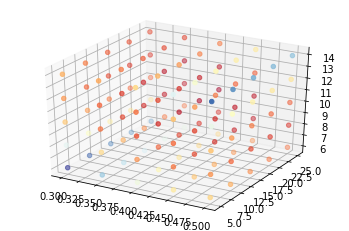

In [8]:
from mpl_toolkits import mplot3d
%matplotlib inline
import matplotlib.pyplot as plt
fig = plt.figure()
ax = plt.axes(projection='3d')
zdata = results_df['Win Bonus'].tolist()
xdata = results_df['Yearly Reset'].tolist()
ydata = results_df['Home Bonus'].tolist()
color_data = results_df['Accuracy'].tolist()
ax.scatter3D(xdata,ydata,zdata,c=color_data,cmap='RdYlBu_r')
plt.show()

After 3 Iterations of parameter looping, the optimal combination was selected

In [9]:
results_df.sort_values(by='Accuracy', ascending=False).head(1)

,Win Bonus,Yearly Reset,Home Bonus,Accuracy
72,10,0.4,25,10.491971


## Run Model with optimized parameters to calculate ELO Rating for each team from 2010-2019 Seasons

In [2]:
elo_dict = {}
team_date_dict = {}
for school in scores['away_team'].unique().tolist():
    team_date_dict[school] = {}
    elo_dict[school] = 1500
for school in scores['home_team'].unique().tolist():
    team_date_dict[school] = {}
    elo_dict[school] = 1500
HFA = 25
learning_rate = 10
reset_rate = .4
for year in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]:
    season = scores[scores['season'] == year].reset_index(drop=True)
    season = season.sort_values(by='date').reset_index(drop=True)
    for key in elo_dict.keys():
        elo_dict[key] = ((elo_dict[key] - 1500) * reset_rate) + 1500
    for row in range(len(season)):
        date = season['date'].iloc[row]
        away_team = season['away_team'].iloc[row]
        away_score = season['away_score'].iloc[row]
        home_team = season['home_team'].iloc[row]
        home_score = season['home_score'].iloc[row]
        home_elo = elo_dict[home_team]
        away_elo = elo_dict[away_team]
        home_expected = (home_elo+HFA) / (home_elo+HFA+away_elo)
        elo_diff = home_elo+HFA-away_elo
        home_actual = home_score / (home_score + away_score)
        if home_score > away_score:
            home_bonus = learning_rate
        else:
            home_bonus = -learning_rate
        elo_change = 100*(home_actual-home_expected) + home_bonus
        elo_dict[home_team] = home_elo + elo_change
        team_date_dict[home_team][date] = elo_dict[home_team]
        elo_dict[away_team] = away_elo - elo_change
        team_date_dict[away_team][date] = elo_dict[away_team]

## Input school name to vizualize ELO Vs. Time

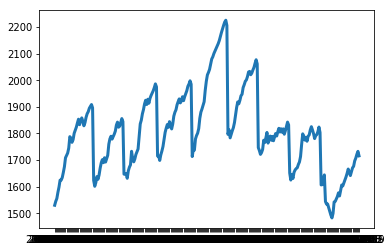

In [87]:
import matplotlib.pyplot as plt
team_input = 'Converse Judson'
dates = team_date_dict[team_input].keys()
elo = team_date_dict[team_input].values()
plt.plot(dates,elo,linewidth=3)
plt.show()

## Build DataFrame that contains each school's ELO at end of 2019 Season

In [6]:
df = pd.DataFrame()
df['School'] = elo_dict.keys()
df['ELO'] = elo_dict.values()

In [7]:
df.sort_values(by='ELO', ascending=False).head(10)

,School,ELO
346,Universal City Randolph,2030.696255
290,San Antonio Cole,2012.119612
237,San Antonio Wagner,1996.910341
292,Pleasanton,1967.893615
30,San Antonio Antonian,1946.214848
217,Houston Yates,1875.689493
159,Cibolo Steele,1865.629529
1085,Tomball Concordia Lutheran,1865.064837
297,Marion,1854.735905
39,Houston Clear Lake,1844.643371


## Build Dataframe that contains each schools Elo History

In [8]:
df_history = pd.DataFrame()
team_list = []
date_list = []
elo_list = []
for team in team_date_dict.keys():
    for date in team_date_dict[team].keys():
        team_list.append(team)
        date_list.append(date)
        elo_list.append(team_date_dict[team][date])
df_history['Team'] = team_list
df_history['Date'] = date_list
df_history['ELO'] = elo_list
df_history['season'] = 2000
df_history['month'] = df_history['Date'].str.split('-',3).str[1]
df_history['month'] = df_history['month'].astype(int)
df_history['year'] = df_history['Date'].str.split('-',3).str[0]
df_history['year'] = df_history['year'].astype(int)
for season in [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019]:
    df_history.loc[(((df_history['year'] == season-1) & (df_history['month'] >= 10)) | ((df_history['year'] == season) & (df_history['month'] <= 4))), 'season'] = season

### Top High School Basketball Programs in San Antonio based on average ELO Rating over last 10 Years

In [9]:
top_programs = df_history.groupby('Team').mean()['ELO'].sort_values(ascending=False).to_frame()
top_programs = top_programs.reset_index(drop=False)
top_programs.index = top_programs.index + 1
top_programs.columns = ['School', 'Average ELO']

In [10]:
classification_df = pd.read_csv('sa_divisions.csv', index_col=0)
classification_df['School'] = classification_df['School'].drop_duplicates(keep='first')
classification_mapper = dict(zip(classification_df['School'], classification_df['Division']))

In [11]:
top_programs['Division'] = top_programs['School'].map(classification_mapper)

Top Ten San Antonio 6A Schools 

In [12]:
top_programs_6a = top_programs[top_programs['Division'] == '6A'].reset_index(drop=True)
top_programs_6a.index = top_programs_6a.index + 1
top_programs_6a[['School', 'Average ELO']].head(10)

,School,Average ELO
1,San Antonio Brennan,1832.441237
2,Converse Judson,1804.259781
3,San Antonio Churchill,1757.226036
4,San Antonio Antonian,1742.652860
5,San Antonio Central Catholic,1713.553019
6,San Antonio Brandeis,1693.334070
7,San Antonio Reagan,1671.252305
8,Schertz Clemens,1664.989640
9,San Antonio East Central,1651.716321
10,Cibolo Steele,1633.371120


Top Ten San Antonio 5A Schools

In [13]:
top_programs_5a = top_programs[top_programs['Division'] == '5A'].reset_index(drop=True)
top_programs_5a.index = top_programs_5a.index + 1
top_programs_5a[['School', 'Average ELO']].head(10)

,School,Average ELO
1,San Antonio Alamo Heights,1773.694644
2,San Antonio Wagner,1723.066474
3,San Antonio Sam Houston,1679.216205
4,San Antonio Lanier,1642.946939
5,Kerrville Tivy,1641.607461
6,Boerne Champion,1615.836529
7,Victoria East,1580.373647
8,Somerset,1563.881772
9,San Antonio Harlandale,1537.477584
10,San Antonio Brackenridge,1534.709724


Top Ten San Antonio 4A Schools

In [14]:
top_programs_4a = top_programs[top_programs['Division'] == '4A'].reset_index(drop=True)
top_programs_4a.index = top_programs_4a.index + 1
top_programs_4a[['School', 'Average ELO']].head(10)

,School,Average ELO
1,Boerne,1810.325097
2,Hondo,1647.249977
3,La Vernia,1603.094229
4,Brookshire Royal,1559.489996
5,Wimberley,1558.281520
6,Devine,1557.370866
7,Pleasanton,1500.939553
8,Crystal City,1486.853989
9,Round Rock Concordia,1468.854755
10,Beeville Jones,1459.966583


Top Ten San Antonio 3A Schools

In [15]:
top_programs_3a = top_programs[top_programs['Division'] == '3A'].reset_index(drop=True)
top_programs_3a.index = top_programs_3a.index + 1
top_programs_3a[['School', 'Average ELO']].head(10)

,School,Average ELO
1,San Antonio Cole,1791.223260
2,Universal City Randolph,1748.956527
3,Blanco,1553.560651
4,San Antonio Gervin Academy,1537.538300
5,Stockdale,1494.101488
6,Comfort,1468.545667
7,Dilley,1440.248980
8,Natalia,1323.284761
9,Lytle,1320.292583


Top Ten San Antonio Other Schools

In [16]:
top_programs_other = top_programs[top_programs['Division'] == 'Other'].reset_index(drop=True)
top_programs_other.index = top_programs_other.index + 1
top_programs_other[['School', 'Average ELO']].head(10)

,School,Average ELO
1,Sabinal,1715.586540
2,San Antonio Milton Lee Academy,1715.135352
3,Harper,1688.197528
4,San Antonio FEAST,1585.739165
5,San Antonio St. Anthony,1569.072850
6,San Antonio Stacey,1559.339439
7,San Antonio Cornerstone,1477.824880
8,Knippa,1477.155439
9,Utopia,1379.606362


# Appendix

### Run ELO Calculations Again To create DataFrame that shows ELO algorithm process

In [74]:
import math
elo_dict = {}
team_date_dict = {}
prediction_list = []
accuracy_score_list = []
home_elo_list = []
away_elo_list = []
elo_change_list = []
home_score_list = []
away_score_list = []
home_team_list = []
away_team_list = []
spread_list = []
date_list = []
season_list = []
for school in scores['away_team'].unique().tolist():
    team_date_dict[school] = {}
    elo_dict[school] = 1500
for school in scores['home_team'].unique().tolist():
    team_date_dict[school] = {}
    elo_dict[school] = 1500
HFA = 25
learning_rate = 10
reset_rate = .4
prediction_sum = 0
game_sum = 0
for year in [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]:
    season = scores[scores['season'] == year].reset_index(drop=True)
    season = season.sort_values(by='date').reset_index(drop=True)
    for key in elo_dict.keys():
        elo_dict[key] = ((elo_dict[key] - 1500) * reset_rate) + 1500
    for row in range(len(season)):
        date = season['date'].iloc[row]
        away_team = season['away_team'].iloc[row]
        away_score = season['away_score'].iloc[row]
        home_team = season['home_team'].iloc[row]
        home_score = season['home_score'].iloc[row]
        home_elo = elo_dict[home_team]
        away_elo = elo_dict[away_team]
        home_expected = (home_elo+HFA) / (home_elo+HFA+away_elo)
        elo_diff = home_elo+HFA-away_elo
        home_actual = home_score / (home_score + away_score)
        if home_score > away_score:
            home_bonus = learning_rate
        else:
            home_bonus = -learning_rate
        elo_change = 100*(home_actual-home_expected) + home_bonus
        elo_dict[home_team] = home_elo + elo_change
        team_date_dict[home_team][date] = elo_dict[home_team]
        elo_dict[away_team] = away_elo - elo_change
        team_date_dict[away_team][date] = elo_dict[away_team]
        home_expected_win_pct = 1/(10**((-1*elo_diff)/400)+1)
        away_expected_win_pct = 1-home_expected_win_pct
        if home_expected_win_pct > 0.5:
            points_home_win = 2*((-100*(home_expected_win_pct-.5)**2) + 100*(home_expected_win_pct-.5))
            points_away_win = -((home_expected_win_pct - .5)*400 - points_home_win)
            spread = 261.14*(home_expected_win_pct)**3 - 509.52*(home_expected_win_pct)**2 + 354.66*(home_expected_win_pct) - 82.5925
            prediction_list.append(str(home_team)+': '+str(home_expected_win_pct*100)[:4]+'%')
        elif home_expected_win_pct < 0.5:
            points_away_win = 2*((-100*(away_expected_win_pct-.5)**2) + 100*(away_expected_win_pct-.5))
            points_home_win = -((away_expected_win_pct - .5)*400 - points_away_win)
            spread = 261.14*(away_expected_win_pct)**3 - 509.52*(away_expected_win_pct)**2 + 354.66*(away_expected_win_pct) - 82.5925
            prediction_list.append(str(away_team)+': '+str((1-home_expected_win_pct)*100)[:4]+'%')
        else:
            points_home_win = 0
            points_away_win = 0
        if home_score > away_score:
            prediction_score = points_home_win
        elif home_score < away_score:
            prediction_score = points_away_win
        else:
            prediction_score = 0
        spread_list.append(-math.ceil(spread))
        accuracy_score_list.append(str(int(prediction_score)))
        elo_change_list.append(int(elo_change))
        home_elo_list.append(home_elo)
        away_elo_list.append(away_elo)
        home_score_list.append(home_score)
        away_score_list.append(away_score)
        home_team_list.append(home_team)
        away_team_list.append(away_team)
        season_list.append(year)
        date_list.append(date)

In [75]:
df_accuracy = pd.DataFrame()
df_accuracy['Date'] = date_list
df_accuracy['Season'] = season_list
df_accuracy['Prediction'] = prediction_list
df_accuracy['Accuracy Score'] = accuracy_score_list
df_accuracy['home_elo'] = home_elo_list
df_accuracy['away_elo'] = away_elo_list
df_accuracy['elo_change'] = elo_change_list
df_accuracy['home_team'] = home_team_list
df_accuracy['away_team'] = away_team_list
df_accuracy['home_score'] = home_score_list
df_accuracy['away_score'] = away_score_list
df_accuracy['spread'] = spread_list
df_accuracy['home_score'] = df_accuracy['home_score'].astype(int)
df_accuracy['away_score'] = df_accuracy['away_score'].astype(int)
df_accuracy['score'] = df_accuracy['home_score'].astype(str)+'-'+df_accuracy['away_score'].astype(str)
df_accuracy = df_accuracy[['home_team', 'home_elo', 'away_team', 'away_elo', 'Prediction', 'spread', 'score', 'Accuracy Score', 'elo_change', 'Season', 'Date']]

### For all 40838 games recorded, displays ELO prediction/spread & ELO change as a result of actual outcome

#### 'score' column is the following format: home score - away score

#### 'elo_change' column shows the change in ELO applied to the home team, the away team is given this change X(-1)

In [86]:
df_accuracy[2000:]

,home_team,home_elo,away_team,away_elo,Prediction,spread,score,Accuracy Score,elo_change,Season,Date
2000,Katy Morton Ranch,1468.741013,Alief Hastings,1517.100531,Alief Hastings: 53.3%,-2,45-58,6,-15,2010,2009-12-15
2001,Comfort,1415.591672,Canyon,1512.202926,Canyon: 60.1%,-4,38-60,18,-20,2010,2009-12-15
2002,Kingsville King,1500.000000,Corpus Christi King,1410.454545,Kingsville King: 65.9%,-5,42-43,-36,-12,2010,2009-12-15
2003,Smithson Valley,1510.387872,San Antonio Reagan,1600.285782,San Antonio Reagan: 59.2%,-3,65-78,16,-13,2010,2009-12-15
2004,Floresville,1385.870138,South San Antonio,1538.181350,South San Antonio: 67.5%,-5,23-39,28,-20,2010,2009-12-15
2005,San Antonio East Central,1558.860146,Schertz Clemens,1440.709594,San Antonio East Central: 69.5%,-6,85-53,31,19,2010,2009-12-15
2006,Willis,1526.147086,Liberty,1493.185300,Willis: 58.2%,-3,72-38,15,24,2010,2009-12-15
2007,Freeport Brazosport,1463.321149,Rosenberg Terry,1529.540553,Rosenberg Terry: 55.9%,-3,60-63,11,-10,2010,2009-12-15
2008,Houston Chavez,1449.224369,Houston Heights,1495.439543,Houston Heights: 53.0%,-2,81-49,-6,22,2010,2009-12-15
2009,San Antonio Highlands,1379.411297,San Antonio Harlan,1489.666636,San Antonio Harlan: 62.0%,-4,70-69,-26,11,2010,2009-12-15
